## Gaussian AR Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example we have Gaussian base distribution and covariance matrix $\Gamma$ structured under AR covariance with $\rho = 0.5, \sigma^2 = 0.5$

We use multi-threading on 8 threads to obtain these MSE results on the following machine, and include MSE results from 100 simulation runs for each scenario.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using QuasiCopula, DelimitedFiles, LinearAlgebra, Random
using DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-2, 2), p)
σ2true = [0.5]
ρtrue = [0.5]
θtrue = [σ2true; ρtrue]
τtrue = 100

# generate data
trueparams = [βtrue; θtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100;

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
σ2MseResult = vec(readdlm("mse_sigma_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
ρMseResult = vec(readdlm("mse_rho_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
fittimes = vec(readdlm("fittimes_multivariate_normal_AR$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.194271942
 0.267542579
 0.333401714
 0.175385498
 0.142589145
 0.160943425
 0.114408786
 0.149422231
 0.18432943
 0.19913938
 0.291209534
 0.256027894
 0.23512361
 ⋮
 1.371969195
 1.532541362
 1.34456271
 1.099195865
 1.372206464
 1.390151943
 1.499666353
 1.230029035
 1.482417115
 1.301627147
 1.216052028
 1.476166957

In [5]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, σ2mse = σ2MseResult, ρmse = ρMseResult,
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)


msedf = filter(x -> !isnan(x.fittimes), msedf)

timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[5]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.212978,0.00792299,200,0.205055,0.220901,0.00106489
2,100,5,0.305009,0.0211421,500,0.283866,0.326151,0.000610017
3,100,10,0.391787,0.0250899,1000,0.366697,0.416877,0.000391787
4,100,15,0.507431,0.0281887,1500,0.479242,0.53562,0.000338287
5,100,20,0.532627,0.0270376,2000,0.505589,0.559664,0.000266313
6,100,25,0.589586,0.0267275,2500,0.562859,0.616314,0.000235834
7,1000,2,0.235703,0.00590242,2000,0.229801,0.241606,0.000117852
8,1000,5,0.271829,0.00472799,5000,0.267101,0.276557,5.43657e-5
9,1000,10,0.365205,0.0114854,10000,0.353719,0.37669,3.65205e-5


In [6]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βρσ2τcoverage = readdlm("beta_rho_sigma_coverage_multivariate_normal_AR$(nsims)reps_sim.csv", ',')

m = 2

covdf = DataFrame(Matrix(transpose(βρσ2τcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["ρ"];["σ2"]; ["τ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["ρ"];["σ2"]; ["τ"]])])
covdfdisplay


,people_obs,β1,β2,β3,ρ
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.64, 0.0482418)","(0.55, 0.05)","(0.6, 0.0492366)","(0.89, 0.0314466)"
2,N: 100 ni: 5,"(0.7, 0.0460566)","(0.7, 0.0460566)","(0.72, 0.0451261)","(0.83, 0.0377525)"
3,N: 100 ni: 10,"(0.76, 0.0429235)","(0.76, 0.0429235)","(0.81, 0.0394277)","(0.75, 0.0435194)"
4,N: 100 ni: 15,"(0.78, 0.0416333)","(0.77, 0.0422953)","(0.82, 0.0386123)","(0.77, 0.0422953)"
5,N: 100 ni: 20,"(0.7, 0.0460566)","(0.75, 0.0435194)","(0.79, 0.040936)","(0.82, 0.0386123)"
6,N: 100 ni: 25,"(0.7, 0.0460566)","(0.78, 0.0416333)","(0.77, 0.0422953)","(0.81, 0.0394277)"
7,N: 1000 ni: 2,"(0.7, 0.0460566)","(0.74, 0.0440844)","(0.78, 0.0416333)","(0.86, 0.0348735)"
8,N: 1000 ni: 5,"(0.75, 0.0435194)","(0.78, 0.0416333)","(0.84, 0.0368453)","(0.86, 0.0348735)"
9,N: 1000 ni: 10,"(0.85, 0.035887)","(0.84, 0.0368453)","(0.91, 0.0287623)","(0.73, 0.0446196)"


In [7]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
σ2MseResult_1 = vec(readdlm("mse_sigma_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
ρMseResult_1 = vec(readdlm("mse_rho_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
θMseResult_1 = (σ2MseResult_1 .+ ρMseResult_1) ./ 2
τMseResult_1 = vec(readdlm("mse_tau_multivariate_normal_AR$(nsims)reps_sim.csv", ','))
βρσ2τcoverage_1 = readdlm("beta_rho_sigma_coverage_multivariate_normal_AR$(nsims)reps_sim.csv", ',')

p = 3
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf = DataFrame(βmse = βMseresult_1, thetamse = θMseResult_1, τmse = τMseResult_1,
    samplesize = sample_sizes, obssize = obs_sizes)


msedf = deepcopy(msedf)
rename!(msedf, ["betamse"
    "thetamse"
        "taumse"
    "samplesize"
 "obssize"]);

mses = [msedf[!, :betamse]; msedf[!, :thetamse]; msedf[!, :taumse]]

obssize = collect([repeat(msedf[!, :obssize], 3)]...) 

samplesize = collect([repeat(msedf[!, :samplesize], 3)]...) 

parameters = collect([repeat(string.([:beta, :theta, :tau]), inner = nsims * length(ns) * length(samplesizes))]...)

labels = collect([repeat(["Gaussian AR with Identity Link"], 3 * nsims * length(ns) * length(samplesizes))]...) # ;

mse_df = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, labels = labels)

#5 of the 30,000 simulations did not converge, filter out
mse_df = filter(x -> !isnan(x.mse), mse_df)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
mse_df = filter(x -> x.mse < 40000, mse_df)

,mse,obssize,samplesize,parameters,labels
,Float64,String,String,String,String
1,0.0001057,2,100,beta,Gaussian AR with Identity Link
2,4.40257e-5,2,100,beta,Gaussian AR with Identity Link
3,1.11162e-5,2,100,beta,Gaussian AR with Identity Link
4,2.2906e-5,2,100,beta,Gaussian AR with Identity Link
5,2.61697e-5,2,100,beta,Gaussian AR with Identity Link
6,0.00011653,2,100,beta,Gaussian AR with Identity Link
7,0.000109954,2,100,beta,Gaussian AR with Identity Link
8,0.000149556,2,100,beta,Gaussian AR with Identity Link
9,2.37951e-5,2,100,beta,Gaussian AR with Identity Link


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


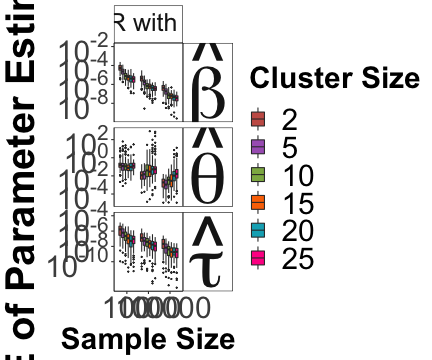

RObject{VecSxp}


In [8]:
### working on figure next
@rput mse_df

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(mse_df)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]
msedfR[parameters == "tau",y_min := 10^-8]
msedfR[parameters == "tau",y_max := 10^-4]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta', 'tau'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[]), tau = expression(hat(bold(tau)))))
msedfR$robust = factor(msedfR$labels, levels = c('Gaussian AR with Identity Link'),
    labels = c(expression(paste("Gaussian AR with Identity Link")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))




#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min))  
"""

In [9]:
R"""
ggsave('updated_msefacetplot_Normal_AR.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_Normal_AR.png"
